# TCC - Detecção de Apneia do sono com sinais EEG

In [1]:
# imports
import pyedflib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import wfdb
import datetime
import time
import warnings
import seaborn as sns

from matplotlib.image import imsave
from pathlib import Path
from scipy import signal
from pyts.image import RecurrencePlot
warnings.filterwarnings("ignore")

## Explorando DB #1 

### Lendo base e definindo funções auxiliares

Nota: Para cada segundo do experimento de um paciente, existem 128 amostras do sinal.

In [261]:
project_folder_path = '/home/samantha.athayde/Documents/tcc/base1/st-vincents-university-hospital-university-college-dublin-sleep-apnea-database-1.0.0/files/'
project_folder_path

'/home/samantha.athayde/Documents/tcc/base1/st-vincents-university-hospital-university-college-dublin-sleep-apnea-database-1.0.0/files/'

In [262]:
# no contexto do database, só temos 2 canais eeg, C3 e C4
def read_eeg_signals_from_db1(patient_rec_path, signals):
    patient_rec_file = pyedflib.EdfReader(patient_rec_path)

    file_signal_labels = patient_rec_file.getSignalLabels()

    print("=========================================================================")
    print("Signals in file: ")
    print(file_signal_labels)
    print(f"Recording duration: {patient_rec_file.getFileDuration() / (60 * 60)} H")

    print("\n=========================================================================")
    print(f"Signals of interest: {signals}")

    sigbufs = np.zeros((len(signals), patient_rec_file.getNSamples()[3]))
    print(f"EEG signals dataset shape: {sigbufs.shape}")

    sigbufs[0, :] = patient_rec_file.readSignal(3) # C3A2
    sigbufs[1, :] = patient_rec_file.readSignal(4) # C4A1

    patient_rec_file.close()

    return sigbufs


In [263]:
def beautify_time(seconds):
    return str(datetime.timedelta(seconds=seconds))

In [264]:
patient_ucddb002_file_name = '/home/samantha.athayde/Documents/tcc/base1/st-vincents-university-hospital-university-college-dublin-sleep-apnea-database-1.0.0/files/ucddb002.rec'
patient_ucddb002_file_name

'/home/samantha.athayde/Documents/tcc/base1/st-vincents-university-hospital-university-college-dublin-sleep-apnea-database-1.0.0/files/ucddb002.rec'

In [265]:
patient_ucddb002_eeg_signals = read_eeg_signals(patient_ucddb002_file_name, ['C3A2', 'C4A1'])
patient_ucddb002_eeg_signals

In [266]:
def plot_event(event_name, start_time, duration, channel):
    time_hms = start_time.split(':')
    start_second = int(time_hms[0])*60*60 + (int(time_hms[1])*60) + int(time_hms[2])
    
    event_start = start_second * 128
    event_end = event_start + (128*duration)
    
    x = np.arange(event_start, event_end)
    y = channel[event_start:event_end]
    
    plt.figure(figsize=(8, 6),)
    plt.plot(x, y)
    plt.title(event_name)
    
    plt.xlabel('Sample')
    plt.ylabel('Signal')
    
    print(y.shape, x.shape)
  

In [267]:
plot_event("APNEA-O", "01:40:48", 15, patient_ucddb002_eeg_signals[0]) # C3A2

TypeError: 'NoneType' object is not subscriptable

(2176,) (2176,)


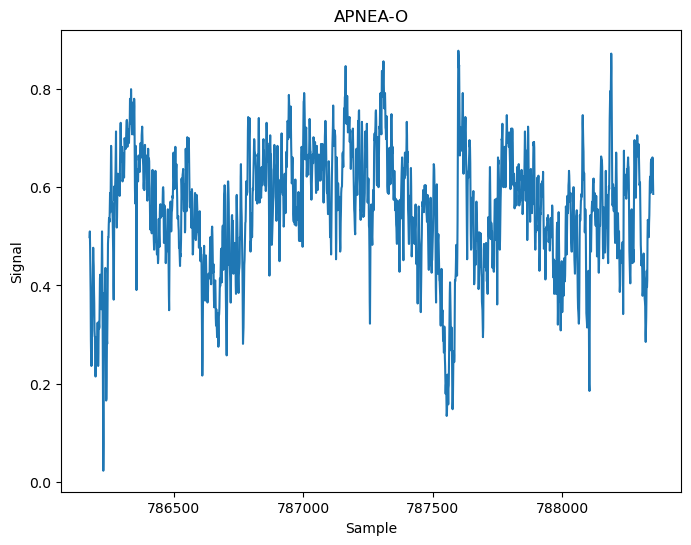

In [ ]:
plot_event("APNEA-O", "01:42:22", 17, patient_ucddb002_eeg_signals[0])

### Lendo informações sobre os pacientes

In [ ]:
subjects_raw = pd.read_excel('./st-vincents-university-hospital-university-college-dublin-sleep-apnea-database-1.0.0/files/SubjectDetails.xls')

In [ ]:
subjects = subjects_raw.loc[:, ~subjects_raw.columns.str.contains('^Unnamed')]
subjects

,S/No,Study Number,Height (cm),Weight (kg),Gender,PSG Start Time,PSG AHI,BMI,Age,Epworth Sleepiness Score,Study Duration (hr),Sleep Efficiency (%),No of data blocks in EDF
0,1,UCDDB002,172,100.3,M,0:11:04,23,33.9,54,16,6.2,84,22470
1,2,UCDDB003,179,102.0,M,23:07:50,51,31.8,48,13,7.3,81,26478
2,3,UCDDB005,176,100.4,M,23:28:42,13,32.4,65,19,6.9,63,24798
3,4,UCDDB006,185,103.5,M,23:57:14,31,30.2,52,3,6.7,89,24267
4,5,UCDDB007,183,84.0,M,23:30:22,12,25.1,47,15,6.8,90,24405
5,6,UCDDB008,145,59.8,F,23:29:11,5,28.4,63,1,6.4,64,23041
6,7,UCDDB009,180,101.5,M,22:35:22,12,31.3,52,19,7.7,80,27759
7,8,UCDDB010,174,119.0,M,22:51:18,34,39.3,38,2,7.6,92,27211
8,9,UCDDB011,188,101.0,M,22:47:38,8,28.6,51,8,7.5,60,27030
9,10,UCDDB012,179,97.5,M,23:23:21,25,30.4,51,16,7.2,85,25941


In [ ]:
len(subjects)

25

### Lendo anotações dos eventos respiratorios

A ideia é ler as anotações dos eventos respiratorios de cada paciente, transforma-las em um dataframe que depois é adicionado em uma lista contendo as anotações de todos os pacientes.

In [ ]:
subjects_notes_list = []

In [ ]:
subjects_notes_path = './st-vincents-university-hospital-university-college-dublin-sleep-apnea-database-1.0.0/files/'

In [ ]:
def read_annotations(notes_path):
    # pegando apenas as colunas necessárias
    notes_df_raw = pd.read_fwf(notes_path, skiprows=2)
    notes_df = notes_df_raw[['Time', 'Type', 'Duration']]
    
    # removendo linhas com valores nulos
    notes_df_clean = notes_df.dropna()
    
    return notes_df_clean

In [ ]:
for patient in range(number_of_subjects):
    patient_notes_path = subjects_notes_path + subjects['Study Number'][patient].lower() + '_respevt.txt'
    
    patient_notes = read_annotations(patient_notes_path)
    subjects_notes_list.append(patient_notes)

In [ ]:
subjects_notes_list[0] # anotações do primeiro paciente

,Time,Type,Duration
0,00:29:13,HYP-C,16.0
1,00:59:46,HYP-C,20.0
2,01:01:37,HYP-C,13.0
3,01:02:25,HYP-C,13.0
4,01:07:47,HYP-C,14.0
...,...,...,...
119,05:01:26,HYP-C,21.0
120,05:02:09,HYP-C,31.0
121,05:03:03,HYP-C,19.0
122,05:05:03,APNEA-M,12.0


### Criando o dataset que será utilizado na CNN

Cada sinal de cada experimento será divido em frames de comprimento pré-definido e também com um shift pré-definido para permitir overlap e aumentar a quantidade de dados para treino.

A classificação de cada frame será o equivalente a classificação do ponto médio (do dataframe), ou seja, se o ponto médio estiver dentro de um evento de APNEA-C, essa será a classificação do frame.

**Classificações:**
- HYP-C (Hypopnea)
- HYP-O
- HYP-M
- APNEA-C (Central)
- APNEA-O (Obstructive)
- APNEA-M (Mixed)

**Legenda:**
- HYP -> Hypopnea
- C   -> Central
- O   -> Obstructive
- M   -> Mixed


In [ ]:
# se generalized_apnea for True, o dataset desconsidera as ramificações da apneia (O, C e M)
generalized_apnea = True
classify_hyp = False

frame_length = 10 # medido em segundos
frame_shift = 8 # também medido em segundos, SAMPLE_RATE_FREQUENCY % frame_shift == 0
SAMPLE_RATE_FREQUENCY = 128

## Explorando DB #2

### Lendo infos sobre pacientes

In [ ]:
pacientes_db2_df = pd.read_csv('./physionet.org/files/challenge-2018/1.0.0/age-sex.csv')
pacientes_db2_df

,Record,Sex,Age
0,te03-0024,M,31
1,te03-0031,M,55
2,te03-0032,M,50
3,te03-0037,M,44
4,te03-0041,F,54
...,...,...,...
1978,tr14-0268,M,49
1979,tr14-0272,F,62
1980,tr14-0276,M,32
1981,tr14-0278,F,73


In [ ]:
# m -> M
print(f"numero de pacientes: {len(pacientes_db2_df)}")
m_pacientes_count = pacientes_db2_df['Sex'].value_counts()
m_pacientes_count

numero de pacientes: 1983


M    1287
F     693
m       3
Name: Sex, dtype: int64

In [ ]:
header = wfdb.rdheader('./physionet.org/files/challenge-2018/1.0.0/training/tr03-0005/tr03-0005')
header.sig_name

['F3-M2',
 'F4-M1',
 'C3-M2',
 'C4-M1',
 'O1-M2',
 'O2-M1',
 'E1-M2',
 'Chin1-Chin2',
 'ABD',
 'CHEST',
 'AIRFLOW',
 'SaO2',
 'ECG']

In [ ]:
data_db2 = wfdb.rdrecord('./physionet.org/files/challenge-2018/1.0.0/training/tr03-0005/tr03-0005')

In [ ]:
data_db2.sig_len
data_db2.p_signal[0]

array([-9.00000000e+00,  5.00000000e+00, -5.00000000e+00,  9.00000000e+00,
        5.00000000e+00,  1.20000000e+01, -2.10000000e+01,  1.60000000e+01,
       -4.10000000e+01, -2.00000000e+00,  3.90000000e+01,  9.65346761e+01,
       -5.30000000e-02])

In [ ]:
def import_arousals(file_name):
    import h5py
    f = h5py.File(file_name, 'r')
    arousals = np.array(f['data']['arousals'])
    return arousals

In [ ]:
a = import_arousals('./physionet.org/files/challenge-2018/1.0.0/training/tr03-0005/tr03-0005-arousal.mat')
np.unique(a, return_counts=True)

(array([-1.,  0.,  1.]), array([2605102, 2355871,  186027], dtype=int64))

In [ ]:
annotations_db2 = wfdb.rdann('./physionet.org/files/challenge-2018/1.0.0/training/tr03-0005/tr03-0005', 'arousal')

In [ ]:
wfdb.rdheader('./physionet.org/files/challenge-2018/1.0.0/training/tr03-0005/tr03-0005').sig_len / 200 / (60 * 60)

7.148611111111111

In [ ]:
elapsed_time = wfdb.rdheader('./physionet.org/files/challenge-2018/1.0.0/training/tr03-0005/tr03-0005').get_elapsed_time(400)
str(elapsed_time)

'0:00:02'

In [ ]:
wfdb.rdsamp('./physionet.org/files/challenge-2018/1.0.0/training/tr03-0005/tr03-0005')

(array([[-9.00000000e+00,  5.00000000e+00, -5.00000000e+00, ...,
          3.90000000e+01,  9.65346761e+01, -5.30000000e-02],
        [-3.60000000e+01,  2.00000000e+00, -3.30000000e+01, ...,
          9.30000000e+01,  9.65346761e+01, -1.03000000e-01],
        [-2.30000000e+01,  2.00000000e+00, -2.30000000e+01, ...,
          6.20000000e+01,  9.65346761e+01,  6.00000000e-03],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -6.00000000e+00,  4.95918212e-01,  5.43000000e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          3.00000000e+00,  4.95918212e-01, -7.28000000e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          4.00000000e+00,  4.95918212e-01, -7.20000000e-02]]),
 {'fs': 200,
  'sig_len': 5147000,
  'n_sig': 13,
  'base_date': None,
  'base_time': None,
  'units': ['uV',
   'uV',
   'uV',
   'uV',
   'uV',
   'uV',
   'uV',
   'uV',
   'uV',
   'uV',
   'uV',
   '%',
   'mV'],
  'sig_name

In [ ]:
# lista das samples anotadas
annotations_db2.sample

240

In [ ]:
annotations_db2.aux_note

['W',
 'N1',
 '(resp_centralapnea',
 'resp_centralapnea)',
 'W',
 'N1',
 'N2',
 'W',
 '(resp_centralapnea',
 'N1',
 'resp_centralapnea)',
 '(resp_centralapnea',
 'N2',
 'resp_centralapnea)',
 '(arousal_rera',
 'arousal_rera)',
 '(arousal_rera',
 'arousal_rera)',
 'W',
 'N1',
 'W',
 '(resp_centralapnea',
 'N1',
 'resp_centralapnea)',
 'W',
 '(arousal_rera',
 'N1',
 'arousal_rera)',
 'W',
 '(resp_centralapnea',
 'resp_centralapnea)',
 'N1',
 '(resp_centralapnea',
 'resp_centralapnea)',
 '(resp_centralapnea',
 'resp_centralapnea)',
 'N2',
 'N3',
 'N2',
 '(resp_hypopnea',
 'resp_hypopnea)',
 'N1',
 '(arousal_rera',
 'N2',
 'arousal_rera)',
 '(arousal_rera',
 'arousal_rera)',
 'W',
 'N1',
 '(resp_centralapnea',
 'resp_centralapnea)',
 '(resp_centralapnea',
 'N2',
 'resp_centralapnea)',
 '(resp_hypopnea',
 'resp_hypopnea)',
 '(arousal_rera',
 'arousal_rera)',
 'W',
 'N1',
 'N2',
 'R',
 'W',
 '(resp_obstructiveapnea',
 'N1',
 'resp_obstructiveapnea)',
 '(arousal_rera',
 'N2',
 'arousal_rera)'

In [ ]:
annotations_db2.create_label_map(inplace=False)

,label_store,symbol,description
0,0,,Not an actual annotation
1,1,N,Normal beat
2,2,L,Left bundle branch block beat
3,3,R,Right bundle branch block beat
4,4,a,Aberrated atrial premature beat
5,5,V,Premature ventricular contraction
6,6,F,Fusion of ventricular and normal beat
7,7,J,Nodal (junctional) premature beat
8,8,A,Atrial premature contraction
9,9,S,Premature or ectopic supraventricular beat


## Explorando DB #3

In [ ]:
paciente_header = wfdb.rdheader("./physionet.org/files/slpdb/1.0.0/slp01a")

In [ ]:
paciente_header.sig_name

['ECG', 'BP', 'EEG (C4-A1)', 'Resp (sum)']

In [ ]:
print(f"sobre paciente: {paciente_header.comments}")

sobre paciente: ['44 M 89 32-01-89']


In [ ]:
subject_notes = wfdb.rdann("./physionet.org/files/slpdb/1.0.0/slp01a", "st")

In [ ]:
subject_notes.sample

array([      1,    7500,   15000,   22500,   30000,   37500,   45000,
         52500,   60000,   67500,   75000,   82500,   90000,   97500,
        105000,  112500,  120000,  127500,  135000,  142500,  150000,
        157500,  165000,  172500,  180000,  187500,  195000,  202500,
        210000,  217500,  225000,  232500,  240000,  247500,  255000,
        262500,  270000,  277500,  285000,  292500,  300000,  307500,
        315000,  322500,  330000,  337500,  345000,  352500,  360000,
        367500,  375000,  382500,  390000,  397500,  405000,  412500,
        420000,  427500,  435000,  442500,  450000,  457500,  465000,
        472500,  480000,  487500,  495000,  502500,  510000,  517500,
        525000,  532500,  540000,  547500,  555000,  562500,  570000,
        577500,  585000,  592500,  600000,  607500,  615000,  622500,
        630000,  637500,  645000,  652500,  660000,  667500,  675000,
        682500,  690000,  697500,  705000,  712500,  720000,  727500,
        735000,  742

In [ ]:
subject_notes.get_contained_labels()

In [ ]:
subject_notes.aux_note

['4 LA LA',
 '4 LA',
 '4 LA',
 '4 L L L',
 '4 L',
 '4 L',
 '4 L L',
 '4 L',
 '4 L',
 '4 L L',
 '4 L L L',
 '4 LA',
 '3 HA',
 '3 H LA',
 '3 LA',
 '2 LA',
 '2 LA',
 '2 LA',
 '3 LA',
 '3 LA LA',
 '3 LA',
 '3 L LA',
 '3 LA',
 '3',
 '3 LA LA',
 '3 LA',
 '3 LA',
 '3 L',
 '3 L',
 '4 LA',
 '4 LA LA',
 '4 LA',
 '4 L',
 '4 L LA',
 '4 LA LA',
 '4 L LA',
 '4 LA HA LA',
 '4',
 '4 LA LA',
 '3',
 '3',
 '3',
 '3',
 '2',
 '3',
 '2',
 '2 H',
 '2',
 '2',
 '2 H',
 '2',
 '2',
 '2',
 '2',
 '2 LA',
 '2 LA LA',
 '2',
 '2 L LA',
 '2 LA',
 '2',
 '2',
 '2',
 '2 LA LA',
 'W',
 '1 LA',
 '2',
 '2 L',
 '2 L',
 '2 LA',
 '2 LA',
 '2 LA',
 '2 LA',
 'W LA',
 'W',
 '2',
 '2 LA LA',
 '2 L',
 '2 LA',
 '2 L',
 '2 LA',
 '2 LA',
 '2 LA',
 '2 LA L',
 '2',
 '2 L LA',
 '2 LA',
 '2 LA',
 '2 LA LA',
 '2',
 '2 LA',
 '2 LA',
 '2 L',
 '2 LA',
 '3 LA',
 '3 LA LA',
 '3 LA',
 '3 L',
 '3 LA LA',
 '3 LA',
 '3 LA',
 '3 LA',
 '3 LA L',
 '3 LA',
 '3 LA LA',
 '3 L',
 '3 L LA',
 '3 LA',
 '3 L',
 '3 L',
 '4 LA LA',
 '3 LA',
 '3 LA LA',
 '3 LA',

In [ ]:
patient_signals = wfdb.rdrecord("./physionet.org/files/slpdb/1.0.0/slp01a")

In [ ]:
patient_signals.units

['mV', 'mmHg', 'mV', 'l']

## Pré-processamento de dados

In [2]:
def read_eeg_signals(database, signal):
    '''
    Reads EEG signals from specified database and returns list of signals for each patient.

    Keyword arguments:

    database -- name of the database to be read

    signal -- name of the eeg signal to be read (c3 or c4)
    '''
    UCDDB_PATH = './physionet.org/files/ucddb/1.0.0/'
    CHALLENGE18_PATH = './physionet.org/files/challenge-2018/1.0.0/training'
    SLPDB_PATH = './physionet.org/files/slpdb/1.0.0'

    subjects_eeg_signals = None
    if (database == "ucddb"):
        print("reading ucddb database...")

        subjects_info_db1 = pd.read_excel(UCDDB_PATH + 'SubjectDetails.xls')

        subjects = subjects_info_db1['Study Number']
        number_of_subjects = len(subjects)

        signal = 3 if signal == 'c3' else 4

        subjects_eeg_signals = (pyedflib.EdfReader(
            UCDDB_PATH + subjects[p].lower() + '.rec').readSignal(signal) for p in range(number_of_subjects))
  

    elif (database == 'challenge18'):
        print("reading challenge18 database...")

        subjects_records = open(
            './physionet.org/files/challenge-2018/1.0.0/training/RECORDS', 'r').read().splitlines()

        number_of_subjects = len(subjects_records)

        signal = 2 if signal == 'c3' else 3

        subjects_eeg_signals = (wfdb.rdrecord(
                f"{CHALLENGE18_PATH}/{subjects_records[p]}/{subjects_records[p][:-1]}").p_signal[:, signal] for p in range(number_of_subjects))
       

    elif (database == 'slpdb'):
        print("reading slpdb database...")

        subjects_records = open(
            './physionet.org/files/slpdb/1.0.0/RECORDS', 'r').read().splitlines()

        number_of_subjects = len(subjects_records)

        subjects_eeg_signals = (wfdb.rdrecord(
            f"{SLPDB_PATH}/{subjects_records[p]}").p_signal[:, 2] for p in range(number_of_subjects))

    return subjects_eeg_signals


In [3]:
def create_frames(db_eeg_signals, sample_frequency, frame_length, frame_shift, resample=False):
    '''
    Create frames of specified length given an array of EEG signals

    Keyword arguments:

    db_eeg_signals -- array of EEG signals

    sample_frequency -- sample frequency of database

    frame_length -- desired frame length

    frame_shift -- desired frame shift
    '''
    
    resample_frequency = 250

    frame_samples = sample_frequency * frame_length

    for subject_eeg_signal in db_eeg_signals:
        step = frame_shift * sample_frequency

        eeg_signal_length = len(subject_eeg_signal)
        
        if resample:
            yield np.array([signal.resample(subject_eeg_signal[i:frame_samples+i], resample_frequency * frame_length) for i in range(0, eeg_signal_length - frame_samples, step)])
        else:
            yield np.array([subject_eeg_signal[i:frame_samples+i] for i in range(0, eeg_signal_length - frame_samples, step)])


In [4]:
def extract_seconds_from_time(time_str):
    x = time.strptime(time_str, "%H:%M:%S")
    return datetime.timedelta(hours=x.tm_hour, minutes=x.tm_min, seconds=x.tm_sec).total_seconds()

def compare_datetimes(datetime_to_compare, datetime_ref):
    res = (datetime.datetime.strptime(datetime_to_compare, '%H:%M:%S') - datetime_ref).total_seconds()
    if res < 0:
        return abs(res + (24*60*60))
    return res

def read_annotations(database):
    '''
    Read annotations from specified database

    Keyword arguments:

    database -- name of the database to be read
    '''
    UCDDB_PATH = './physionet.org/files/ucddb/1.0.0/'
    CHALLENGE18_PATH = './physionet.org/files/challenge-2018/1.0.0/training'
    SLPDB_PATH = './physionet.org/files/slpdb/1.0.0'

    subjects_annotations = []
    if (database == "ucddb"):
        subjects_info_db1 = pd.read_excel(UCDDB_PATH + 'SubjectDetails.xls')

        subjects_start_rec = subjects_info_db1['PSG Start Time']

        subjects = subjects_info_db1['Study Number']
        number_of_subjects = len(subjects)

        for s in range(number_of_subjects):
            subject_annotation_df_raw = pd.read_fwf(f"{UCDDB_PATH}{subjects[s].lower()}_respevt.txt", skiprows=2)[['Time', 'Type', 'Duration']]
            subject_rec_annotations = subject_annotation_df_raw.dropna()
            subject_rec_annotations.drop(['Type'], axis=1, inplace=True)

            # subjects_start_rec[s]
            subjects_start_rec_datetime = datetime.datetime.strptime(subjects_start_rec[s], '%H:%M:%S')
            subject_rec_annotations["Time"] = subject_rec_annotations['Time'] .apply(lambda time : compare_datetimes(time, subjects_start_rec_datetime))

            subjects_annotations.append(subject_rec_annotations)
        

    elif (database == 'challenge18'):
        subjects_records = open(
            './physionet.org/files/challenge-2018/1.0.0/training/RECORDS', 'r').read().splitlines()

        number_of_subjects = len(subjects_records)

        
        for s in range(number_of_subjects):
            subject_rec_path = f"{CHALLENGE18_PATH}/{subjects_records[s]}{subjects_records[s]}"[:-1]

            subject_rec_header = wfdb.rdheader(subject_rec_path)
            subject_rec_annotations = wfdb.rdann(subject_rec_path, "arousal")

            
            subject_rec_annotations_df = pd.DataFrame()

            subject_rec_annotations_samples = subject_rec_annotations.sample

            apnea_annotations_time = []
            apnea_annotations_duration = []

            annotations = subject_rec_annotations.aux_note

            start_time_event = 0
            for i in range(len(annotations)):
                if "(resp" in annotations[i]:
                    start_time_event = subject_rec_header.get_elapsed_time(time_value=subject_rec_annotations_samples[i]).seconds
                    apnea_annotations_time.append(start_time_event)


                elif "resp" in annotations[i]:
                    apnea_annotations_duration.append(subject_rec_header.get_elapsed_time(time_value=subject_rec_annotations_samples[i]).seconds - start_time_event)
                
            subject_rec_annotations_df.insert(0, "Time", apnea_annotations_time)
            subject_rec_annotations_df.insert(1, "Duration", apnea_annotations_duration)


            subjects_annotations.append(subject_rec_annotations_df)    

    elif (database == 'slpdb'):
        subjects_records = open(
            './physionet.org/files/slpdb/1.0.0/RECORDS', 'r').read().splitlines()

        number_of_subjects = len(subjects_records)

        for s in range(number_of_subjects):
            subject_rec_path = f"{SLPDB_PATH}/{subjects_records[s]}"

            subject_rec_header = wfdb.rdheader(subject_rec_path)
            subject_rec_annotations = wfdb.rdann(subject_rec_path, "st")

            subject_rec_annotations_df = pd.DataFrame()

            annotations_samples = subject_rec_annotations.sample
            annotations = subject_rec_annotations.aux_note

            apnea_annotations_time = []
            apnea_annotations_duration = []

            start_time_event = 0
            for i in range(len(annotations)):
                has_apnea = False

                for char in annotations[i]:
                    char = char.lower()
                    if char == "c" or char == "o" or char == "x" or char == "h":
                        has_apnea = True
                        break
                
                if has_apnea:
                    start_time_event = subject_rec_header.get_elapsed_time(time_value=annotations_samples[i]).seconds
                    apnea_annotations_time.append(start_time_event)
                    apnea_annotations_duration.append(30)

            subject_rec_annotations_df.insert(0, "Time", apnea_annotations_time)
            subject_rec_annotations_df.insert(1, "Duration", apnea_annotations_duration)


            subjects_annotations.append(subject_rec_annotations_df) 


    return subjects_annotations


In [5]:
def compare_datetimes(datetime_to_compare, datetime_ref):
    res = (datetime.datetime.strptime(datetime_to_compare, '%H:%M:%S') - datetime_ref).total_seconds()
    if res < 0:
        return abs(res + (24*60*60))
    return res

def read_annotations(database):
    '''
    Read annotations from specified database

    Keyword arguments:

    database -- name of the database to be read
    '''
    UCDDB_PATH = './physionet.org/files/ucddb/1.0.0/'

    subjects_annotations = []
    
    subjects_info_db1 = pd.read_excel(UCDDB_PATH + 'SubjectDetails.xls')

    subjects_start_rec = subjects_info_db1['PSG Start Time']

    subjects = subjects_info_db1['Study Number']
    number_of_subjects = len(subjects)

    for s in range(number_of_subjects):
        subject_annotation_df_raw = pd.read_fwf(f"{UCDDB_PATH}{subjects[s].lower()}_respevt.txt", skiprows=2)[['Time', 'Type', 'Duration']]
        subject_rec_annotations = subject_annotation_df_raw.dropna()
        subject_rec_annotations.drop(['Type'], axis=1, inplace=True)

        # subjects_start_rec[s]
        subjects_start_rec_datetime = datetime.datetime.strptime(subjects_start_rec[s], '%H:%M:%S')
        subject_rec_annotations["Time"] = subject_rec_annotations['Time'] .apply(lambda time : compare_datetimes(time, subjects_start_rec_datetime))

        subjects_annotations.append(subject_rec_annotations)

    return subjects_annotations


In [6]:
def create_frames_labels(frames, frame_length, frame_shift, annotations):
    '''
    Label subject frames given specified annotations

    Keyword arguments:

    frames -- array of frames

    frame_length -- size of frame

    annotations -- subject annotations dataframe
    '''
    event_current_second = 0

    for frame in frames:
        frame_start_second = event_current_second
        frame_end_second = event_current_second + frame_length

        annotations_array = annotations.to_numpy()

        has_apnea = False
        apnea_duration = 0

        for annotation in annotations_array:
            annotation_end = annotation[0] + annotation[1]
            if annotation[0] > frame_end_second:
                break

            elif (annotation[0] >= frame_start_second and annotation[0] < frame_end_second):
                has_apnea = True
                apnea_duration = frame_end_second - annotation[0]
                break
            elif (annotation[0] <= frame_start_second and annotation_end >= frame_end_second):
                has_apnea = True
                apnea_duration = frame_length
                break
            elif  (annotation_end > frame_start_second and annotation_end <= frame_end_second):
                has_apnea = True
                apnea_duration = annotation_end - frame_start_second
                break
            
        
        if has_apnea:
            yield np.array([frame, 1, apnea_duration])
        else:
            yield np.array([frame, 0, apnea_duration])
        event_current_second += frame_shift
    

In [7]:
# CONFIGURAÇÃO PARA CRIAÇÃO DE FRAMES

# FRAME_LENGTH e FRAME_SHIFT estão em segundos
FRAME_LENGTH = 10
FRAME_SHIFT = 10

In [8]:
def plot_frame(frame, frame_length, event_name):
    event_start = 0
    event_end = event_start + (250*frame_length)
    
    print(len(frame))

    x = np.arange(event_start, event_end)
    y = frame
    
    plt.figure(figsize=(8, 6),)
    plt.plot(x, y)
    plt.title(event_name)
    
    plt.xlabel('Sample')
    plt.ylabel('Signal')
    plt.savefig()
    print(y.shape, x.shape)

In [8]:
def save_frame_rp_v2(frame, type=None, name=None):
    transformer = RecurrencePlot(threshold=0.25)
    rp = transformer.transform(np.array([frame]))

    cwd = Path.cwd()

    if type == 1:
        imsave(Path(cwd, "data-raw", "apnea", f"{name}.png"), rp[0], cmap='binary')
    else:
        imsave(Path(cwd, "data-raw", "normal", f"{name}.png"), rp[0], cmap='binary')

In [11]:
def generate_rp_images(database):
    if (database == "ucddb"):
        ucddb_annotations = read_annotations('ucddb')
        ucddb_eeg_signals = read_eeg_signals('ucddb', 'c4')
        ucddb_frames = create_frames(ucddb_eeg_signals,128, FRAME_LENGTH, FRAME_SHIFT, resample=True)

        subject_count = 0
        
        for subject_frames in ucddb_frames:
            
            frame_count = 0
            subject_frames_with_label = create_frames_labels(subject_frames, FRAME_LENGTH, FRAME_SHIFT, ucddb_annotations[subject_count])

            print(f"generating rp images for patient #{subject_count}")
            for frame_with_label in subject_frames_with_label:
                apnea_time_slice = int(frame_with_label[2])
                label = frame_with_label[1]

                if label == 1 and apnea_time_slice == 9:
                    save_frame_rp_v2(frame_with_label[0], type=1, name=f"{subject_count}_{frame_count}_{apnea_time_slice}_apnea")
                # elif label == 0:
                #     save_frame_rp_v2(frame_with_label[0], type=0, name=f"{subject_count}_{frame_count}_normal")
                frame_count += 1
            subject_count+=1

In [12]:
generate_rp_images("ucddb")

reading ucddb database...
generating rp images for patient #0
generating rp images for patient #1
generating rp images for patient #2
generating rp images for patient #3
generating rp images for patient #4
generating rp images for patient #5
generating rp images for patient #6
generating rp images for patient #7
generating rp images for patient #8
generating rp images for patient #9
generating rp images for patient #10
generating rp images for patient #11
generating rp images for patient #12
generating rp images for patient #13
generating rp images for patient #14
generating rp images for patient #15
generating rp images for patient #16
generating rp images for patient #17
generating rp images for patient #18
generating rp images for patient #19
generating rp images for patient #20
generating rp images for patient #21
generating rp images for patient #22
generating rp images for patient #23
generating rp images for patient #24


Processing images from patient #0


<AxesSubplot: xlabel='patient0', ylabel='count'>

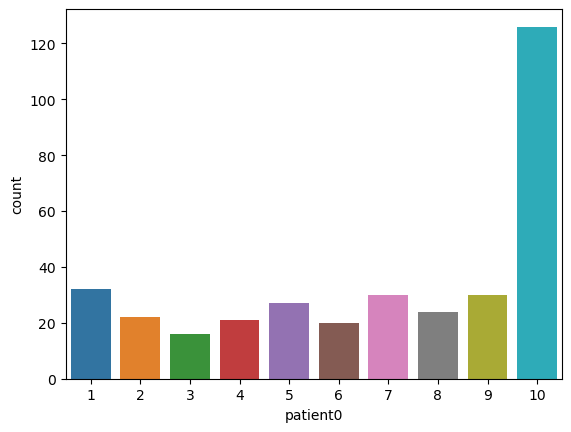

In [87]:
from os import walk

data_raw_apnea_src_path = Path(Path.cwd(), "data-raw", "apnea")
data_raw_normal_src_path = Path(Path.cwd(), "data-raw", "normal")

apnea_imgs = []
normal_imgs = []

for (dirpath, dirnames, filenames) in walk(data_raw_apnea_src_path):
    apnea_imgs.extend(filenames)
    break

for (dirpath, dirnames, filenames) in walk(data_raw_apnea_src_path):
    normal_imgs.extend(filenames)
    break


patients_apnea_distribution = []

for p in range(1):
    patient_apnea_distribution = {f"patient{p}": []}

    print(f"Processing images from patient #{p}")
    apnea_imgs_p = list(filter(lambda x : x.split('_')[0] == str(p), apnea_imgs))

    for image in apnea_imgs_p:
        apnea_slice = image.split('_')[2]
        patient_apnea_distribution[f"patient{p}"].append(int(apnea_slice))
    
    patients_apnea_distribution.append(patient_apnea_distribution)

# print(patients_apnea_distribution[0])
df = pd.DataFrame(data=patients_apnea_distribution[0])
sns.countplot(df, x="patient0")
